## RLlib para RL multiagente

In [1]:
# HIDDEN
import gym
import numpy as np

# References for this notebook:
# https://github.com/sven1977/rllib_tutorials/blob/main/ray_summit_2021/tutorial_notebook.ipynb
# https://github.com/anyscale/ray-summit-2022-training/blob/main/ray-rllib/ex_02_create_multiagent_rllib_env.ipynb

In [2]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR) # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [22]:
# HIDDEN
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

#### RL multiagente

- Hasta ahora hemos tratado con un agente
- La RL multiagente se ocupa de múltiples agentes
- Puede ser competitivo, por ejemplo, dos partes que realizan transacciones monetarias
- Puede ser cooperativo, por ejemplo, dos robots que intentan completar una tarea juntos
- Mira [este divertido vídeo](https://www.youtube.com/watch?v=Lu56xVlZ40M) para ver un juego competitivo de escondite

Notas:

Relación con la teoría de juegos, especialmente en los escenarios competitivos.

#### Arena multiagente

![](img/multi-agent-arena-6x6.png)

Notas:

Este juego de arena será nuestro ejemplo de funcionamiento.

Tenemos dos agentes, el agente 1 y el agente 2. En este caso tienen los mismos espacios de acciones y de observaciones, pero funciones de recompensa (críticamente) diferentes. El agente 1 obtiene una recompensa positiva si explora un nuevo campo cuadrado, y una recompensa negativa si colisiona con el agente 2. El agente 2 obtiene una recompensa positiva si colisiona con el agente 2. Así que, en cierto modo, se trata de un juego de pillar, en el que el agente 2 intenta atrapar al agente 1, pero el agente 1 también tiene el objetivo adicional de intentar explorar el territorio en lugar de limitarse a huir. Como el campo es de 6x6, hay 36 casillas. Nuestro espacio de observación es MultiDiscreto(36,36) porque contiene la ubicación del agente 1 (discreto 36) y del agente 2 (también discreto 36).

El agente 2 se mueve primero en cada paso de tiempo.

#### Probando el entorno multiagente

Importamos la env (código disponible en el GitHub del curso):

In [3]:
from envs_02 import MultiAgentArena

In [4]:
env = MultiAgentArena()
env.reset()

{'agent1': array([ 0, 35]), 'agent2': array([35,  0])}

¿Qué es el espacio de observación?

In [5]:
env.observation_space

MultiDiscrete([36 36])

- Vemos que es `MultiDiscreto([36 36])`.
- En realidad es `MultiDiscreto([36 36])` _para cada agente_.
- El 36 proviene de la cuadrícula de 6x6, y representa una ubicación.
- Ambos agentes observan las ubicaciones de ambos agentes.
- En esta env, ambos agentes observan lo mismo, aunque cada agente se ve a sí mismo "primero".

#### Probando el entorno multiagente

Veamos ahora el espacio de acción:

In [6]:
env.action_space

Discrete(4)

- De nuevo, esto es para cada agente.
- El env utiliza la misma convención que Frozen Lake: 0=izquierda, 1=abajo, 2=derecha, 3=arriba

In [7]:
obs, rewards, dones, _ = env.step({"agent1": 1, "agent2": 0}) # agent 1: down, agent2: up

In [8]:
env.render()

________
|.     |
|1     |
|      |
|      |
|      |
|    2 |
‾‾‾‾‾‾‾‾

R1= 1.0
R2=-0.1 (0 collisions)
Env timesteps=1/50


#### Probando el entorno multiagente

In [9]:
env.render()

________
|.     |
|1     |
|      |
|      |
|      |
|    2 |
‾‾‾‾‾‾‾‾

R1= 1.0
R2=-0.1 (0 collisions)
Env timesteps=1/50


In [10]:
obs

{'agent1': array([ 6, 34]), 'agent2': array([34,  6])}

Esto tiene sentido dado el mapeo del espacio de observación:

```
--------------------
| 0 1 2 3 4 5 |
| 6 7 8 9 10 11 |
|12 13 14 15 16 17 |
|18 19 20 21 22 23 |
|24 25 26 27 28 29 |
|30 31 32 33 34 35 |
--------------------
```

In [11]:
# HIDDEN

n = 6
for i in range(20):
    print("-", end="")
print()
for i in range(n):
    print("|", end="")
    for j in range(n):
        print(f"{j + i*n:2d}", end=" ")
    print("|")
for i in range(20):
    print("-", end="")
    
    
# --------------------------------
# | 0  1  2  3  4  5  6  7  8  9 |
# |10 11 12 13 14 15 16 17 18 19 |
# |20 21 22 23 24 25 26 27 28 29 |
# |30 31 32 33 34 35 36 37 38 39 |
# |40 41 42 43 44 45 46 47 48 49 |
# |50 51 52 53 54 55 56 57 58 59 |
# |60 61 62 63 64 65 66 67 68 69 |
# |70 71 72 73 74 75 76 77 78 79 |
# |80 81 82 83 84 85 86 87 88 89 |
# |90 91 92 93 94 95 96 97 98 99 |
# --------------------------------

# ------------------------
# | 0  1  2  3  4  5  6  7 |
# | 8  9 10 11 12 13 14 15 |
# |16 17 18 19 20 21 22 23 |
# |24 25 26 27 28 29 30 31 |
# |32 33 34 35 36 37 38 39 |
# |40 41 42 43 44 45 46 47 |
# |48 49 50 51 52 53 54 55 |
# |56 57 58 59 60 61 62 63 |
# ------------------------

--------------------
| 0  1  2  3  4  5 |
| 6  7  8  9 10 11 |
|12 13 14 15 16 17 |
|18 19 20 21 22 23 |
|24 25 26 27 28 29 |
|30 31 32 33 34 35 |
--------------------

#### Probando el entorno multiagente

Veamos también las recompensas y los dones que devuelve `step()`:

In [12]:
rewards

{'agent1': 1.0, 'agent2': -0.1}

Aquí vemos que el agente 1 cobró una recompensa de +1 por explorar, mientras que el agente 2 cobró -0,1 por un movimiento regular.

In [13]:
dones

{'agent1': False, 'agent2': False, '__all__': False}

La opción "__all__" es verdadera cuando ambos (todos) los agentes han terminado.

Notas:

En este entorno, los episodios terminan después de 50 pasos de tiempo.

#### Entrenamiento multiagente con RLlib

Podemos ver que PPO admite el entrenamiento multiagente en los documentos de Ray [aquí](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#available-algorithms-overview).

In [14]:
# HIDDEN
from ray.rllib.algorithms.ppo import PPOConfig

In [15]:
# This is the same as before
ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64, 64]})\
)

# This is new
ppo_config = ppo_config.multi_agent(
    policies=["policy1", "policy2"],
    policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "policy1" if agent_id == "agent1" else "policy2"
)

In [16]:
# TODO
# use a default config for the above, to make it cleaner

- Nombramos las políticas y asignamos los ids de los agentes a los ids de las políticas.
- Los identificadores de las políticas deben coincidir en las dos líneas anteriores.
- Los identificadores de los agentes deben coincidir con los del entorno:

In [17]:
obs

{'agent1': array([ 6, 34]), 'agent2': array([34,  6])}

#### Multipolítica

![](img/from_single_agent_to_multi_agent.png)

En el código anterior, definimos _políticas separadas_ para los dos agentes.

#### Formación

Construyamos el algoritmo y entrenemos durante 20 iteraciones:

In [18]:
ppo = ppo_config.build(env=MultiAgentArena)

In [19]:
rewards1 = []
rewards2 = []

In [20]:
for i in range(20):
    result = ppo.train()
    rewards1.append(result['policy_reward_mean']['policy1'])
    rewards2.append(result['policy_reward_mean']['policy2'])

In [21]:
# HIDDEN
# rewards1 = np.array(rewards1)
# rewards2 = np.array(rewards2)

#### Curva de formación

¡Parece que se está aprendiendo!

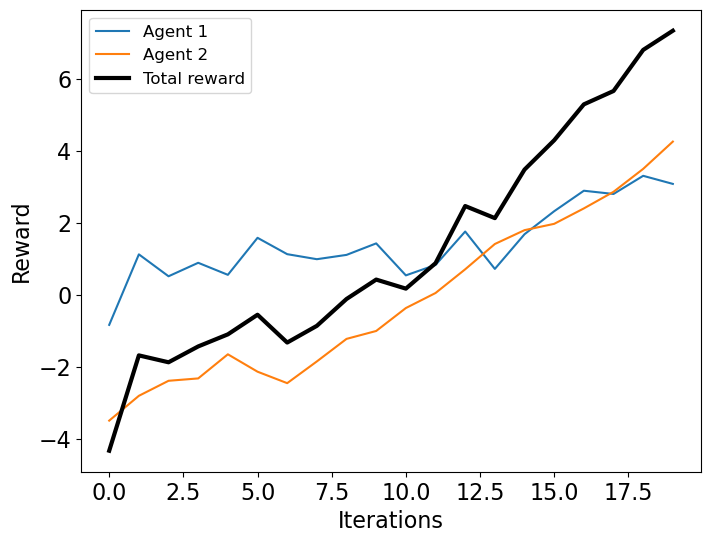

In [23]:
plt.figure(figsize=(8,6))
plt.plot(rewards1, label="Agent 1")
plt.plot(rewards2, label="Agent 2")
plt.plot(np.array(rewards1)+np.array(rewards2), label="Total reward", linewidth=3, color="black")
plt.legend(fontsize=12)
plt.xlabel("Iterations")
plt.ylabel("Reward")

Notas:

Es una mera coincidencia que los dos agentes acaben con una recompensa similar.

#### Un entorno en constante cambio

- Desde la perspectiva de cada agente, el entorno sigue cambiando (a medida que el otro agente aprende).
- A medida que un agente aprende nuevas estrategias, el otro tiene que conocerlas y contrarrestarlas.
- Esto hace que la RL multiagente sea bastante especial

#### Acciones

Cuando queramos utilizar los agentes entrenados, seguiremos utilizando `compute_single_action` pero una vez para cada agente:

In [24]:
obs = env.reset()

In [25]:
env.render()

________
|1     |
|      |
|      |
|      |
|      |
|     2|
‾‾‾‾‾‾‾‾

R1= 0.0
R2= 0.0 (0 collisions)
Env timesteps=0/50


In [26]:
ppo.compute_single_action(obs["agent1"], policy_id="policy1", explore=False)

2

El agente 1 se mueve a la derecha (0=izquierda, 1=abajo, 2=derecha, 3=arriba).

In [27]:
ppo.compute_single_action(obs["agent2"], policy_id="policy2", explore=False)

3

El agente 2 se mueve hacia arriba.

Tenemos que pasar la observación de ese agente, y también la política correcta, ya que estamos utilizando políticas distintas.

#### ¡Apliquemos lo que hemos aprendido!

In [28]:
# HIDDEN
# ppo.save("models/MultiAgent20")

## Casos de uso de RL multiagente
<!-- multiple choice -->

¿Cuál de los siguientes es **NO** un caso de uso razonable de la RL multiagente?

- [ ] Múltiples agentes competidores aprendiendo a jugar un juego adversario.
- [ ] Múltiples agentes cooperativos aprendiendo a jugar un juego cooperativo.
- [ ] Aprender a operar en un mercado financiero con múltiples agentes.
- [x] Lago congelado

## ¿Qué comparten los agentes?
<!-- multiple choice -->

#### Observaciones y acciones: nuestro ejemplo

¿Cuál de las siguientes afirmaciones es cierta **sobre nuestro ejemplo de arena específicamente**?

- [ ] Los agentes comparten el mismo espacio de observación pero tienen espacios de acción diferentes.
- [ ] Los agentes comparten el mismo espacio de acción pero tienen espacios de observación diferentes.
- [ ] Los agentes comparten los mismos espacios de observación y de acción.
- [ ] Los agentes tienen espacios de observación y acción diferentes.

#### Observaciones y acciones: en general

¿Cuál de las siguientes afirmaciones es cierta **sobre la RL multiagente en general**?

- [ ] Los agentes siempre comparten el mismo espacio de observación, pero pueden tener espacios de acción diferentes.
- [ ] Los agentes siempre comparten el mismo espacio de acción, pero pueden tener espacios de observación diferentes.
- [ ] Los agentes siempre comparten los mismos espacios de observación y acción.
- [x] Los agentes pueden tener espacios de observación y de acción diferentes.

#### Recompensas y políticas: nuestro ejemplo

¿Cuál de las siguientes afirmaciones es cierta **sobre nuestro ejemplo de arena específicamente**?

- [ ] Los agentes tienen los mismos objetivos pero diferentes políticas.
- [ ] Los agentes tienen las mismas políticas pero diferentes objetivos.
- [ ] Los agentes tienen los mismos objetivos y las mismas políticas 
- [x] Los agentes tienen objetivos diferentes y políticas diferentes.

## Visualización del agente de la arena entrenado
<!-- coding exercise -->

En las diapositivas hemos entrenado a dos agentes para jugar al juego de la arena. En el código siguiente, restauramos el agente entrenado en las diapositivas. Rellena el código que falta para que podamos ver a los agentes entrenados jugar al juego. Luego, responde a la pregunta de opción múltiple que aparece a continuación.

In [29]:
# EXERCISE

from envs_02 import MultiAgentArena
from ray.rllib.algorithms.ppo import PPOConfig
import time

ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64, 64]})\
    .multi_agent(
        ____=["policy1", "policy2"],
        ____=lambda agent_id, episode, worker, **kwargs: "policy1" if agent_id == "agent1" else "policy2"
    )
)

ppo_arena = ppo_config.build(env=MultiAgentArena)

ppo_arena.restore("models/MultiAgent20/checkpoint_000020")

env = MultiAgentArena(config={"render": True})
obs = env.reset()
dones = {"__all__" : False}
    
while not dones["__all__"]:

    action1 = ppo_arena.compute_single_action(____, policy_id="policy1")
    action2 = ppo_arena.compute_single_action(____, policy_id="policy2")

    obs, rewards, dones, infos = env.step({"agent1": ____, "agent2": ____})

    env.render()
    time.sleep(0.5)

SyntaxError: keyword argument repeated: ____ (2618409439.py, line 8)

In [30]:
# SOLUTION

from envs_02 import MultiAgentArena
from ray.rllib.algorithms.ppo import PPOConfig
import time

ppo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [64, 64]})\
    .multi_agent(
        policies=["policy1", "policy2"],
        policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "policy1" if agent_id == "agent1" else "policy2"
    )
)

ppo_arena = ppo_config.build(env=MultiAgentArena)

ppo_arena.restore("models/MultiAgent20/checkpoint_000020")

env = MultiAgentArena(config={"render": True})
obs = env.reset()
dones = {"__all__" : False}
    
while not dones["__all__"]:

    action1 = ppo_arena.compute_single_action(obs["agent1"], policy_id="policy1")
    action2 = ppo_arena.compute_single_action(obs["agent2"], policy_id="policy2")

    obs, rewards, dones, infos = env.step({"agent1": action1, "agent2": action2})

    env.render()
    time.sleep(0.5)

________
|...   |
|......|
|......|
|.  .2.|
|.  . 1|
|..... |
‾‾‾‾‾‾‾‾

R1= 6.0
R2= 6.0 (10 collisions)
Env timesteps=50/50


#### Elige la opción que mejor describa el comportamiento de los agentes.

- [x] El agente 2 parece "vigilar" parte del territorio no explorado por el agente 1 
- [ ] El Agente 1 consigue explorar todo el territorio en el número de pasos de tiempo dado.
- [ ] El agente 1 consigue evitar colisionar con el agente 2 en el número de pasos de tiempo dado.
- [ ] Los agentes parecen ignorarse mutuamente 